In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 46.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.82MB/s]


In [10]:
# Encoder: Dense(784 -> 128), Dense(128 -> 64), Dense(64 -> 32)
# Decoder: Dense(32 -> 64), Dense(64 -> 128), Dense(128 -> 784)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded, encoded

In [11]:
num_epoch = 10
lr = 0.001

model = AutoEncoder()#.to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epoch):
    run_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)#.to('cuda') # 이미지를 1차원 배열(벡터)로 변환
        optimizer.zero_grad()

        # forward
        decoded, encoded = model(inputs)
        loss = criterion(decoded, inputs)

        # backward
        loss.backward()
        optimizer.step()

        run_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {run_loss/len(trainloader):.4f}")

print('Finish')

Epoch 1, Loss: 0.1951
Epoch 2, Loss: 0.1113
Epoch 3, Loss: 0.0963
Epoch 4, Loss: 0.0912
Epoch 5, Loss: 0.0867
Epoch 6, Loss: 0.0829
Epoch 7, Loss: 0.0806
Epoch 8, Loss: 0.0788
Epoch 9, Loss: 0.0774
Epoch 10, Loss: 0.0761
Finish


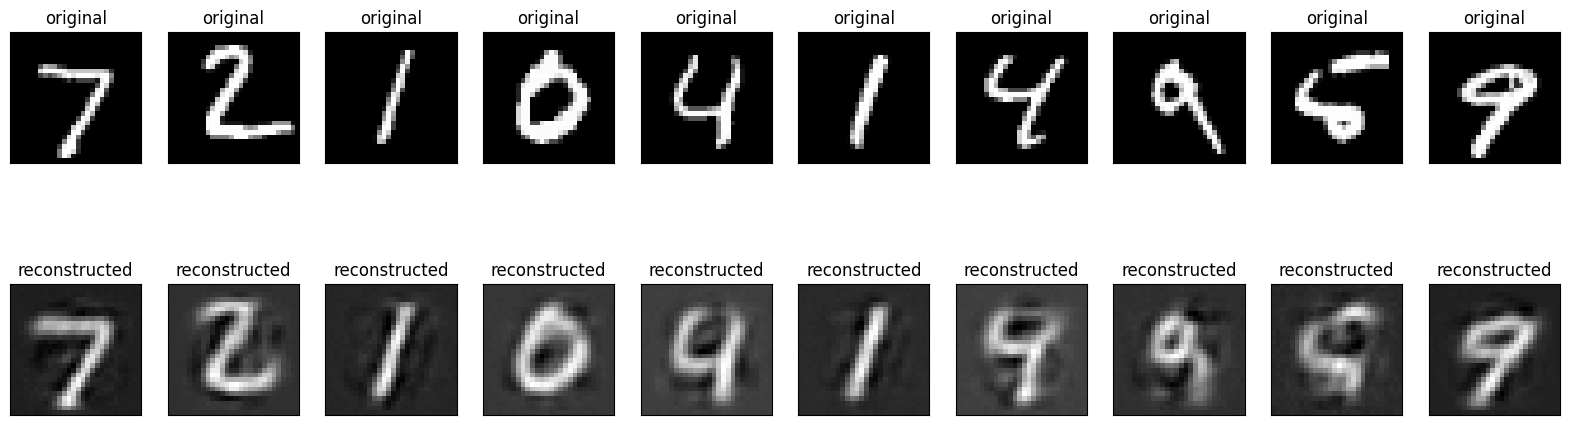

tensor(7)


In [21]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(testloader)
images, labels = next(dataiter)

images_flat = images.view(images.size(0), -1)#.to('cuda')

model.eval()

reconstructed_image_flat, encoded = model(images_flat)
reconstructed_image = reconstructed_image_flat.view(images.size(0), 1, 28, 28)

n_images = 10
plt.figure(figsize=(20, 6))

for i in range(n_images):
    ax = plt.subplot(2, n_images, i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)).squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('original')

    #  Reconstructed images
    ax = plt.subplot(2, n_images, i+1+n_images)
    plt.imshow(np.transpose(reconstructed_image[i].detach().cpu().numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reconstructed')

plt.show()

print(labels[0])

In [23]:
# Encoder: 28x28x1 -> 28x28x16 -> 14x14x16 -> 14x14x32 -> 7x7x32
# Decoder: 7x7x32 -> 14x14x32 -> 14x14x16 -> 28x28x16  -> 28x28x1
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 7x7x32

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded, encoded

Epoch 1, Loss: 0.9674
Epoch 2, Loss: 0.8515
Epoch 3, Loss: 0.8465
Epoch 4, Loss: 0.8441
Epoch 5, Loss: 0.8427
Epoch 6, Loss: 0.8417
Epoch 7, Loss: 0.8409
Epoch 8, Loss: 0.8402
Epoch 9, Loss: 0.8397
Epoch 10, Loss: 0.8393


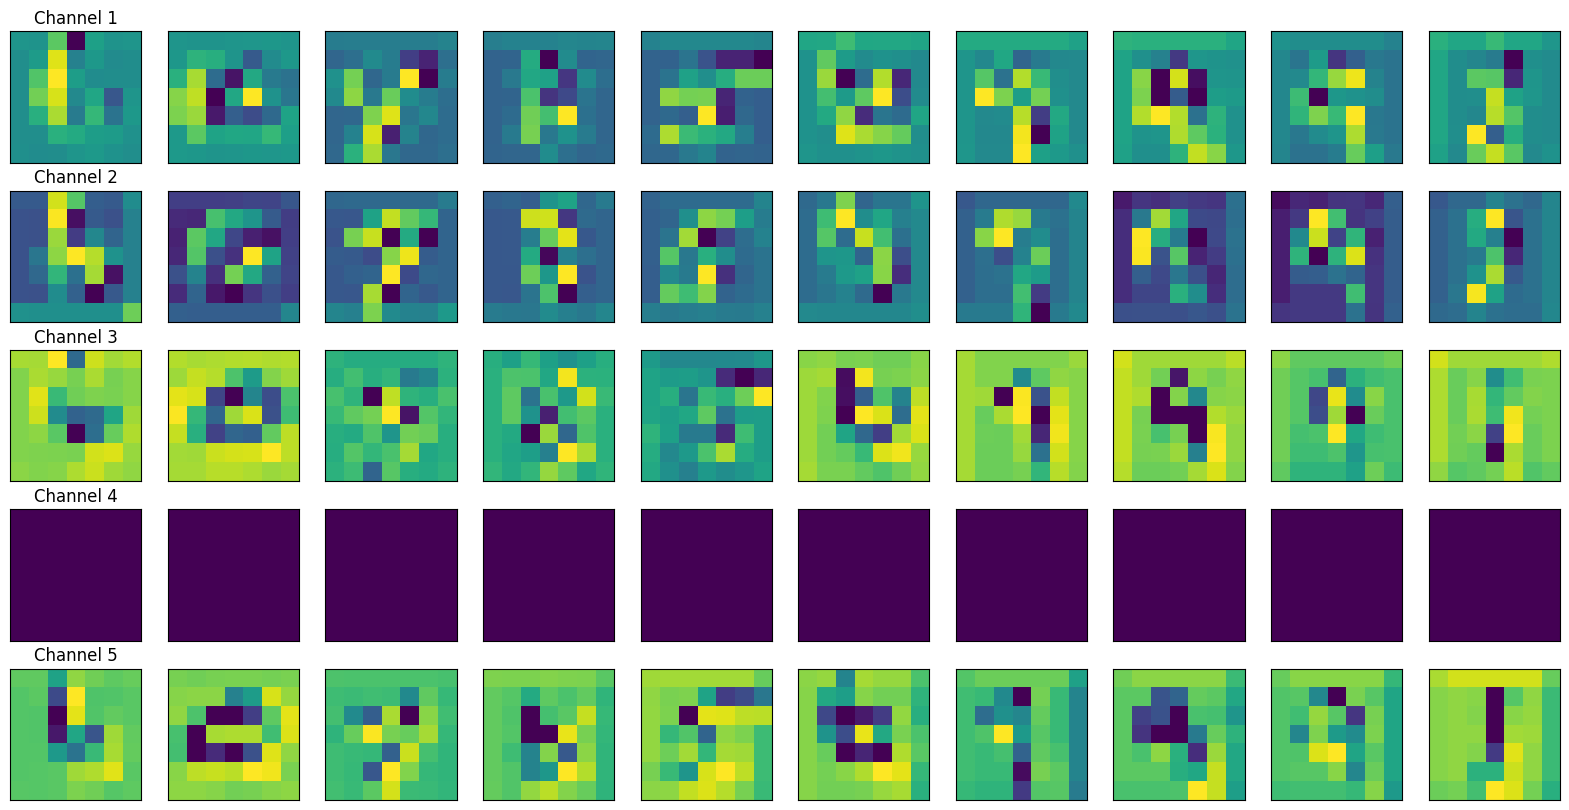

Finish


In [24]:
import matplotlib.pyplot as plt
import numpy as np

model = CNNAutoEncoder()#.to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# training loop
num_epoch = 10
num_channels_to_show = 5

plt.figure(figsize=(20, 10))

for epoch in range(num_epoch):
    run_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer.zero_grad()

        outputs, encoded_feat = model(inputs)

        loss = criterion(outputs, inputs)

        # backward
        loss.backward()
        optimizer.step()

        run_loss += loss.item()


    for c in range(num_channels_to_show):
        ax = plt.subplot(num_channels_to_show, num_epoch, epoch + c * num_epoch+1)
        encoded_img_channel = encoded_feat[epoch, c, :, :].detach().cpu().numpy()
        plt.imshow(encoded_img_channel, cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if epoch == 0 and c >= 0:
            ax.set_title(f'Channel {c+1}')

    print(f"Epoch {epoch+1}, Loss: {run_loss/len(trainloader):.4f}")
    if epoch == num_epoch:
        print('Finish')

plt.show()
